# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.13054275814349137
 0.07307535522314013
 0.008822738808347386
 0.9359579782513314
 0.5785368205998714
 0.9110734870639927
 0.5360641003422772
 0.18291128997502493
 0.38343271999449013
 0.8889533972740439
 0.16456093014493467
 0.4110484334702632
 0.4638950503028677
 ⋮
 0.30727741537157294
 0.6832671027181888
 0.2182830162823648
 0.5896803982967159
 0.5936031894992247
 0.07014157073158489
 0.11454324867077115
 0.5859313430349076
 0.35807515561835923
 0.542809429761239
 0.9790174876861051
 0.12120632169036705

In [2]:
sum(a)

4.9984810199113125e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.003914 seconds (1 allocation: 16 bytes)


4.9984810199113125e6

In [4]:
@time sum(a)

  0.004281 seconds (1 allocation: 16 bytes)


4.9984810199113125e6

In [5]:
@time sum(a)

  0.005312 seconds (1 allocation: 16 bytes)


4.9984810199113125e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `C:\Users\puruv\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\puruv\Projects\Introduction-to-Julia\Project.toml`
  No Changes to `C:\Users\puruv\Projects\Introduction-to-Julia\Manifest.toml`


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

LoadError: IOError: could not spawn `gcc -fPIC -O3 -msse3 -xc -shared -o 'C:\Users\puruv\AppData\Local\Temp\jl_S7cOfFgiD4.dll' -`: no such file or directory (ENOENT)

In [9]:
c_sum(a)

LoadError: UndefVarError: c_sum not defined

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

LoadError: UndefVarError: c_sum not defined

In [11]:
c_sum(a) - sum(a)  

LoadError: UndefVarError: c_sum not defined

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [15]:
c_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1270 samples with 1 evaluation.
 Range (min … max):  3.489 ms …   8.286 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.750 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.928 ms ± 556.157 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅█▇█▇███▆▆▄▄▃▂                              ▁               ▁
  ████████████████▇███▇▇█▄▅▇█▇▇▆▇▇█▁██▇▅██▄██▇██▄▇▇▆▅▇▅▁▅▅▅▄▄ █
  3.49 ms      Histogram: log(frequency) by time      5.98 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [16]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 3.4893 msec


In [17]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 3.4893

In [18]:
using Plots
gr()

Plots.GRBackend()

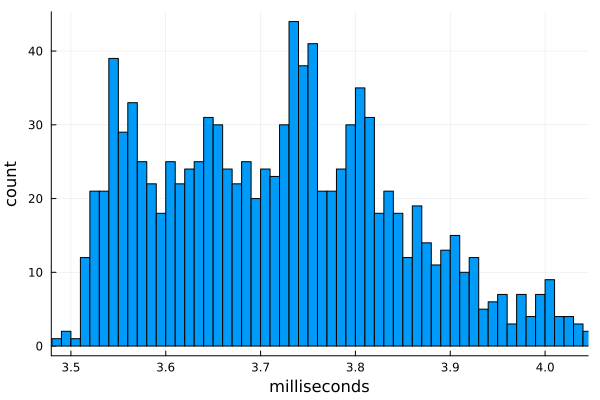

In [19]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 2703 samples with 1 evaluation.
 Range (min … max):  1.781 ms …  3.144 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.806 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.833 ms ± 86.937 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▃                                                          
  ██▇▅▇▇▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂ ▃
  1.78 ms        Histogram: frequency by time        2.23 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

1.781208

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [23]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
    Updating `~/Desktop/Introduction-to-Julia/Project.toml`
  [438e738f] + PyCall v1.92.3
    Updating `~/Desktop/Introduction-to-Julia/Manifest.toml`
  [8f4d0f93] + Conda v1.5.2
  [438e738f] + PyCall v1.92.3
  [81def892] + VersionParsing v1.2.0


In [24]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [25]:
pysum(a)

5.000406093458116e6

In [26]:
pysum(a) ≈ sum(a)

true

In [27]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  875.812 ms … 887.689 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     882.182 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   882.005 ms ±   4.940 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █         █       █                           █       █     █  
  █▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁█ ▁
  876 ms           Histogram: frequency by time          888 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [28]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.38288
  "Python built-in" => 875.812
  "C -ffast-math"   => 1.78121

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [29]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
    Updating `~/Desktop/Introduction-to-Julia/Project.toml`
  [8f4d0f93] + Conda v1.5.2
  No Changes to `~/Desktop/Introduction-to-Julia/Manifest.toml`


In [30]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/logankilpatrick/.julia/packages/Conda/sNGum/src/Conda.jl:128


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/logankilpatrick/.julia/conda/3

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.7.5   |       hecd8cb5_1         113 KB
    conda-4.10.3               |   py38hecd8cb5_0         2.9 MB
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following packages will be UPDATED:

  ca-certificates                      2021.5.25-hecd8cb5_1 --> 2021.7.5-hecd8cb5_1
  conda                               4.10.1-py38hecd8cb5_1 --> 4.10.3-py38hecd8cb5_0



ca-certificates-2021 | 113 KB    | #################################### | 100% 
conda-4.10.3         | 2.9 MB    | #################################### | 100% 
Preparing transaction: ...working... done
Verifying transa

In [31]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 2304 samples with 1 evaluation.
 Range (min … max):  1.913 ms …   6.826 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.025 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.148 ms ± 356.848 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ██▆▅▄▄▄▅▅▄▄▃▃▃▃▂▂▂▁ ▁                                       ▁
  ███████████████████████▇▇█▇▇▇▁▇▆▆▆▆▄▇▅▆▆▅▆▅▁▁▁▁▅▄▅▆▅▅▅▄▄▄▄▅ █
  1.91 ms      Histogram: log(frequency) by time      3.63 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [32]:
numpy_sum(a)

5.000406093458153e6

In [33]:
numpy_sum(a) ≈ sum(a)

true

In [34]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 9.38288
  "Python numpy"    => 1.91263
  "Python built-in" => 875.812
  "C -ffast-math"   => 1.78121

# 5. Python, hand-written 

In [35]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7ff7d13c8b80>

In [36]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.012 s …  1.027 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.018 s             ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.019 s ± 6.023 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █       █              █        █                      █  
  █▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  110 s         Histogram: frequency by time         130 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [37]:
sum_py(a)

5.000406093458116e6

In [38]:
sum_py(a) ≈ sum(a)

true

In [39]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "C -ffast-math"       => 1.78121

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [20]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:889

In [21]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1306 samples with 1 evaluation.
 Range (min … max):  3.485 ms …  10.651 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.696 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.821 ms ± 455.987 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂▃███▅▅                                                     
  ▄█████████▇▆▆▅▅▅▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂ ▃
  3.49 ms         Histogram: frequency by time        5.28 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [42]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "Julia built-in"      => 1.8605
  "C -ffast-math"       => 1.78121

# 7. Julia (hand-written) 

In [22]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [23]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 485 samples with 1 evaluation.
 Range (min … max):   9.707 ms …  13.772 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.141 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.300 ms ± 537.860 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆▄▄▇▂▁▃▇▅█▂▁ ▃▂▂  ▁                                           
  ████████████▇████▆█▅▅▆▇▇▇▅▅▅▄▅▅▄▅▅▅▄▃▄▁▄▃▆▃▄▃▄▃▄▃▃▃▁▄▃▁▁▁▃▃▃ ▄
  9.71 ms         Histogram: frequency by time         11.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Julia hand-written"  => 9.387
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "Julia built-in"      => 1.8605
  "C -ffast-math"       => 1.78121

# 8. Julia (hand-written w. simd) 

In [24]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [25]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1326 samples with 1 evaluation.
 Range (min … max):  3.473 ms …   7.719 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.690 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.763 ms ± 293.548 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▃▂▂▇█▇▆▇▆▆▃▁▂                                               
  ▅█████████████▆▆▆▄▅▄▃▄▄▃▃▃▃▃▂▂▂▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂ ▄
  3.47 ms         Histogram: frequency by time        4.92 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [26]:
mysum_simd(a)

4.998481019911269e6

In [49]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 2.37012
  "C"                       => 9.38288
  "Python numpy"            => 1.91263
  "Julia hand-written"      => 9.387
  "Python hand-written"     => 1011.92
  "Python built-in"         => 875.812
  "Julia built-in"          => 1.8605
  "C -ffast-math"           => 1.78121

# Summary

In [50]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............1.8
Julia built-in..............1.9
Python numpy................1.9
Julia hand-written simd.....2.4
C...........................9.4
Julia hand-written..........9.4
Python built-in...........875.8
Python hand-written......1011.9
